# Link Prediction Supervised

EXPLANATION:
For time complexity reasons, we had to consider only a part of the graph (5000 nodes). Of this smaller graph, we considered only the biggest connected component and then we created a dataset formed by the nodes and the links (dfCut). An adjency matrix has been built to check whether two nodes are linked. From the adjency matrix we obtained two lists of not connected nodes that will be part of another dataframe (data). We then create another dataframe (dfCon) in which there are the nodes of the giant component. We created a list of links that can be removed, without removing nodes and avoiding to split the graph in multiple connected components. In the dataframe "data" we added the nodes that can be removed. We than created a graph in which we removed the omissible links. We will use the node2vec algorithm to extract node features from this graph. We train the model on our graph obtaining the features of every node. To validate the performance of our model we split the data into training (70\%) and test (30\%). We then used a logistic regression model.

Import libraries and stuff

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from statistics import mean, stdev
import seaborn as sns
import matplotlib
import random

from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
#read tehe graph from file
G = nx.read_edgelist("edges.csv", delimiter=',', create_using=nx.DiGraph)

In [ ]:
#create df with node lists of csv
df = pd.read_csv('edges.csv', names=['node_1', 'node_2'])

In [ ]:
#create list of nodes from csv
node_1=df["node_1"]
node_2=df["node_2"]

In [ ]:
#reduce number of nodes to take into account
#change number to try different graphs
node_1=node_1[0:5000]
node_2=node_2[0:5000]

In [ ]:
#function to obtain connected component
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [ ]:
#create dataframe with less nodes (but different components)
dfCut= pd.DataFrame({'node_1': node_1, 'node_2': node_2})

In [ ]:
# create graph from reducted list of nodes
G = nx.from_pandas_edgelist(dfCut, "node_1", "node_2", create_using=nx.Graph())

In [ ]:
# create a graph of only connected component
Gc = max(connected_component_subgraphs(G), key=len)


In [ ]:
nx.number_connected_components(Gc)

1

In [ ]:
#obtain nodelist from Gc only one component
node_list= list(Gc.nodes)

In [ ]:
# remove duplicate items from the list (probably useless)
node_list = list(dict.fromkeys(node_list))

In [ ]:
# build adjacency matrix
adj_G2=nx.adjacency_matrix(Gc,nodelist=node_list)

In [ ]:
adj_G2.shape

(2259, 2259)

In [ ]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G2.shape[0])):
  for j in range(offset,adj_G2.shape[1]):
    if i != j:
      if nx.shortest_path_length(Gc,node_list[i],node_list[j]) <=2:
        if adj_G2[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 2259/2259 [09:14<00:00,  4.07it/s] 


In [ ]:
len(all_unconnected_pairs)

20045

In [ ]:
#create lists of unconnected nodes
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

#create df of these
data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link', 0 because not connected
data['link'] = 0

In [ ]:
#list of edges in Gc, built as list of tuples
lista=list(Gc.edges())

In [ ]:
len(Gc.edges())

4306

In [ ]:
#df of connected nodes (only from Gc and not different connected components)
dfCon = pd.DataFrame(lista, columns =['node_1', 'node_2'])

Remove links from connected node pairs

In [ ]:
initial_node_count = len(Gc.nodes)

df_temp = dfCon.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(dfCon.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    df_temp = df_temp.drop(index = i)

100%|██████████| 4306/4306 [01:03<00:00, 67.83it/s]


In [ ]:
len(omissible_links_index)


2048

Data for model training

In [ ]:
# create dataframe of removable edges
df_ghost = dfCon.loc[omissible_links_index]

# add the target variable 'link'
df_ghost['link'] = 1

data = data.append(df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [ ]:
data['link'].value_counts()

0    20045
1     2048
Name: link, dtype: int64

In [ ]:
# drop removable edges
df_partial = dfCon.drop(index=df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(df_partial, "node_1", "node_2", create_using=nx.Graph())

We will use node2vec to obtain feature of nodes

In [ ]:
!pip install node2vec


Train the model

In [ ]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1): 100%|██████████| 50/50 [01:13<00:00,  1.46s/it]


In [ ]:
#apply the model on every node pair of data
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

Fit a logistic regression model

In [ ]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = lr.predict_proba(xtest)


In [ ]:
roc_auc_score(ytest, predictions[:,1])


0.5037800290996549

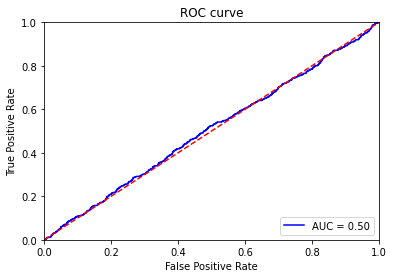

In [ ]:
import sklearn.metrics as metrics

preds = predictions[:,1]
fpr, tpr, threshold = metrics.roc_curve(ytest, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()